Character learning has two components.  First, we need to learn the structure of the automaton representing the character; this remains for future work.

Once we have a structure, we can fit parameters to that structure.  Example parameters include the dynamics of each state and any parameters on guards.  Since we only consider one character at a time, we can abstract the environment into occluding collisions, non-occluding collisions, and hostile collisions.

We'll work with non-hierarchical, non-concurrent hybrid automata for now.  Also, we'll assume left and right movement are mirrored.  Our representation of a state will define, for each variable, whether it has a constant velocity or a constant acceleration (and what that value is); and what transitions are available under what circumstances (a conjunction of abstracted inputs, continuous variable thresholds, timers, any collisions of any type at any normal to the character, and negations of the same).  A state machine is a set of states and an initial state.

In [292]:
# EXECUTE ME!
%matplotlib inline

import pymc3 as pm
import random

import matplotlib.pyplot as plt
import seaborn as sns
#from ipywidgets import interactive, fixed

import numpy as np
import pandas as pd

import theano
import theano.tensor as T

import jumpfinder
from jumpfinder import hold, marioGetX, marioGetY, metroidGetX, metroidGetY
import fceulib

In [2]:
# EXECUTE ME!
RIGHT = 1 << 7
LEFT = 1 << 6
DOWN = 1 << 5
UP = 1 << 4
START = 1 << 3
SELECT = 1 << 2
B = 1 << 1
A = 1 << 0

mario_x = 0x006D
mario_y = 0x00CE

metroid_x = 0x0051
metroid_y = 0x0052

In [ ]:
reload(jumpfinder)

In [3]:
# EXECUTE ME!
jumpButton = A
games = {
    "mario": (
        "mario.nes",
        (hold(0x0, 120) + hold(START | jumpButton, 30) +
         hold(0x0, 150)),
        marioGetX,
        marioGetY
    ),
    "metroid": (
        "metroid.nes",
        (hold(0x0, 60) + hold(START, 1) + hold(0x0, 15) +
         hold(START, 1) + hold(0x0, 600) + hold(LEFT, 400) +
         hold(RIGHT, 30)),
        metroidGetX,
        metroidGetY
    )
}
# CHANGE GAME HERE
(game, startInputs, getx, gety) = games["mario"]
total = 0
emu = fceulib.runGame(game)
for m in startInputs:
    total = total + 1
    emu.step(m, 0x0)

emu.step(0x0, 0x0)
start = fceulib.VectorBytes()
emu.save(start)
allTrials,minHold,maxHold = jumpfinder.runTrials(emu, start, getx, gety, jumpButton)
(len(allTrials),minHold,maxHold)

(28, 1, 28)

Let's learn three linear-or-constant velocity models.

Move count:20 min hold:2
Jumping, record ground->rise from 0 to 10:, prev DY0.0
DYs:[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
10 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0] 1 0 1
Jumping, record rise->fall from 10 to 11 : enter rise, prev DY 0.0
DYs:[-4.0]
11 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 0] 0 1 1
12 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 0, 1] 0 2 1
13 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 0, 1, 2] 0 3 1
14 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 0, 1, 2, 3] 0 4 1
15 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 0, 1, 2, 3, 4] 0 5 1
16 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 0, 1, 2, 3, 4, 5] 0 6 1
17 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 0, 1, 2, 3, 4, 5, 6] 0 7 1
18 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 0, 1, 2, 3, 4, 5, 6, 7] 0 8 1
19 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 0, 1, 2, 3, 4, 5, 6, 7, 8] 0 9 1
Landed, record fall->ground from 11 to 30 : enter ground, prev DY -4.0
DYs:[-4.0, -3.0, -2.0, -2.0, -2.0, -1.0, -1.0, -1.0, 0.0, 1.0, 1.0, 1.0, 2.0, 2.0, 3.0, 3.0, 4.0, 4.0, 3.0]
Move count:22 min hold:2
Jumping, record gr

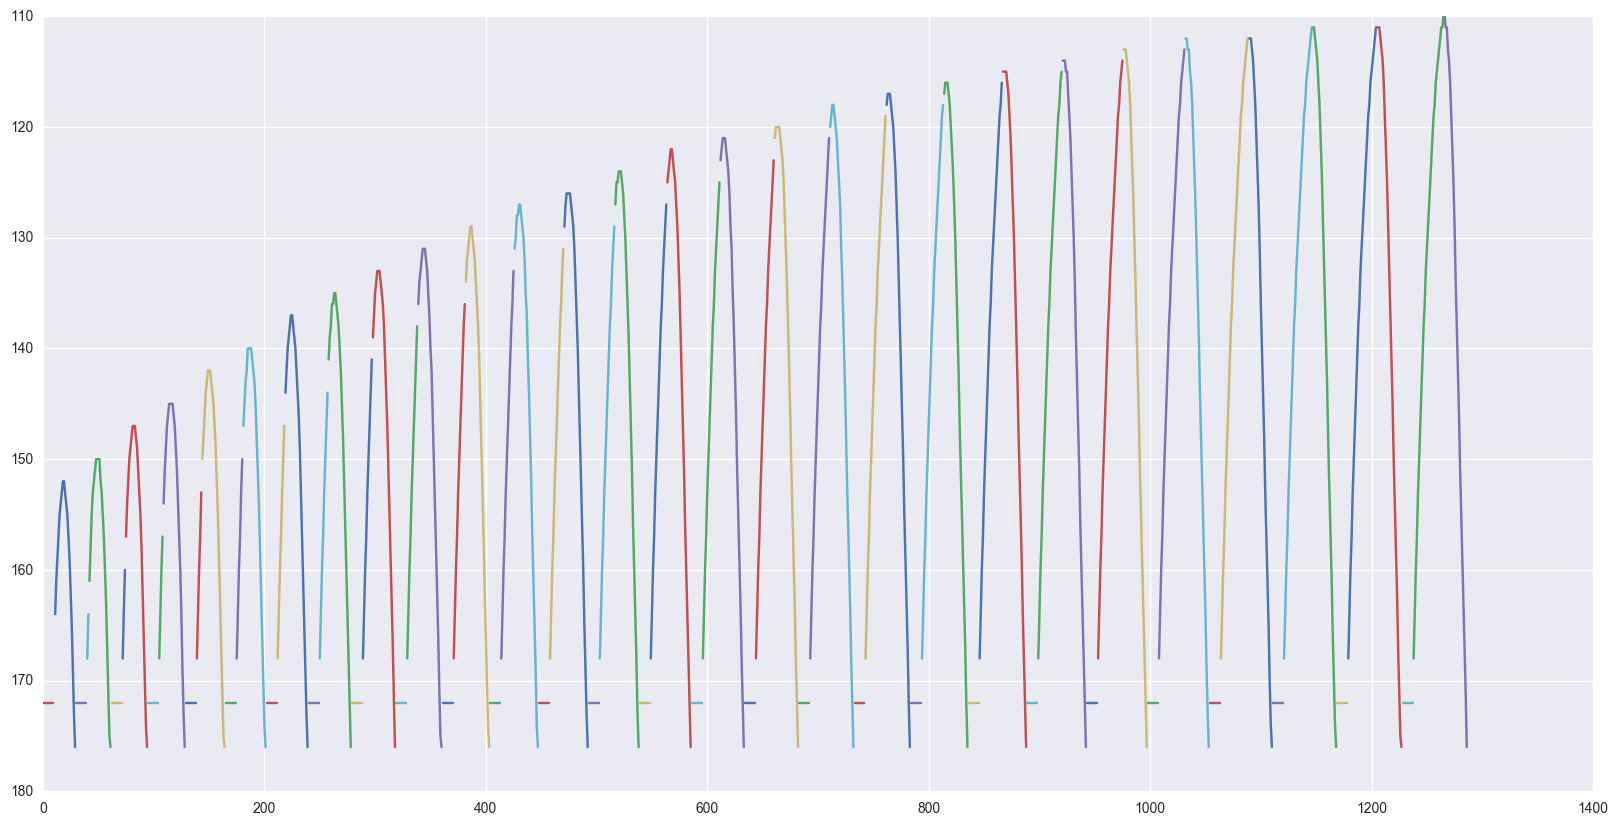

In [282]:
# EXECUTE ME!
mode_names = ["ground", "rise", "fall"]
modes = dict()
for m in mode_names:
    modes[m] = []

def record_run(modes, state, t, vbls, all_vbls):
    frame = pd.DataFrame(vbls)
    #print str(t)+":"+str(all_vbls)
    prev_vbls = dict(x=all_vbls["x"][t],
                     y=all_vbls["y"][t],
                     dx=all_vbls["dx"][t-1 if t > 0 else 0],
                     dy=all_vbls["dy"][t-1 if t > 0 else 0])
    modes[state].append((t, prev_vbls, frame))

t = 0
state_change_t = 0 # start at 1 just so state_change_t - 1 doesn't wrap
trials = allTrials
all_vbls = dict(x=[],y=[],dx=[],dy=[],t=[])
# Tweak the range and increment to get more precise/slower fitting.
for moves, stats in trials:
    state = "ground"
    vbls = dict(x=[],y=[],dx=[],dy=[],t=[])
    start_t = t
    for i in range(10):
        vbls["x"].append(stats.x.allVals[0])
        all_vbls["x"].append(vbls["x"][-1])
        vbls["y"].append(stats.y.allVals[0])
        all_vbls["y"].append(vbls["y"][-1])
        vbls["dx"].append(0.)
        all_vbls["dx"].append(vbls["dx"][-1])
        vbls["dy"].append(0.)
        all_vbls["dy"].append(vbls["dy"][-1])
        vbls["t"].append(t-state_change_t)
        all_vbls["t"].append(vbls["t"][-1])
        t += 1
    print "Move count:"+str(len(moves))+" min hold:"+str(minHold)
    for i, m in enumerate(moves):
        # TODO: Why is jump being held for two frames?  It should just be one for the min mario case, especially if minHold is 1!
        if state == "ground" and stats.y.allVals[i+1] != stats.y.allVals[0]:
            print "Jumping, record ground->rise from "+str(state_change_t)+" to "+str(t)+":"+", prev DY"+str(all_vbls["dy"][state_change_t-1])
            print "DYs:"+str(all_vbls["dy"][state_change_t:])
            record_run(modes, 
                       state,
                       state_change_t,
                       vbls,
                       all_vbls)
            state_change_t = t
            vbls["x"] = []
            vbls["y"] = []
            vbls["dx"] = []
            vbls["dy"] = []
            vbls["t"] = []
            state = "rise"
        elif state == "rise" and not (m & jumpButton) and i >= (minHold-1):
            print "Jumping, record rise->fall from "+str(state_change_t)+" to "+str(t)+" : enter rise, prev DY "+str(all_vbls["dy"][state_change_t-1])
            print "DYs:"+str(all_vbls["dy"][state_change_t:])
            record_run(modes,
                       state,
                       state_change_t,
                       vbls,
                       all_vbls)
            state_change_t = t
            vbls["x"] = []
            vbls["y"] = []
            vbls["dx"] = []
            vbls["dy"] = []
            vbls["t"] = []
            state = "fall"
        vbls["x"].append(stats.x.allVals[i+1])
        all_vbls["x"].append(vbls["x"][-1])
        vbls["y"].append(stats.y.allVals[i+1])
        all_vbls["y"].append(vbls["y"][-1])
        vbls["dx"].append(stats.x.allVals[i+1] - stats.x.allVals[i])
        all_vbls["dx"].append(vbls["dx"][-1])
        vbls["dy"].append(stats.y.allVals[i+1] - stats.y.allVals[i])
        all_vbls["dy"].append(vbls["dy"][-1])
        vbls["t"].append(t-state_change_t)
        all_vbls["t"].append(vbls["t"][-1])
        if t < 20:
            print t,all_vbls["t"],(m&jumpButton),i,(minHold-1)
        t += 1
    print "Landed, record "+state+"->ground from "+str(state_change_t)+" to "+str(t)+" : enter ground, prev DY "+str(all_vbls["dy"][state_change_t-1])
    print "DYs:"+str(all_vbls["dy"][state_change_t:])
    record_run(modes, 
               state,
               state_change_t,
               vbls,
               all_vbls)
    state_change_t = t
    

plt.figure(figsize=(20,10))

for m in modes:
    #print m
    for (run_start, prev_vbls, run_vbls) in modes[m]:
        #print str(run_start)+".."+str(run_start+len(run_vbls["y"]))
        #print "PVs:"+str(prev_vbls)
        plt.plot(run_vbls["t"]+run_start, run_vbls["y"])


plt.gca().invert_yaxis()
plt.show()


In [ ]:
# Original approach with resetp
# MAYBE EXECUTE ME! Then the second-to-last cell.
with pm.Model() as modelReset:
    accs = dict()
    resets = dict()
    resetps = dict()
    resetvals = dict()
    sigs = dict()
    run_params = dict()
    for m in modes:
        accs[m] = dict()
        resets[m] = dict()
        resetps[m] = dict()
        resetvals[m] = dict()
        sigs[m] = dict()
        # This is totally just from modifying existing linear regression code for pymc3
        # I'm using one acc per mode and one initial DY per mode, but really the DY should
        #  be per transition INTO the mode, i.e. mode->mode pair/transition ID.
        # One initial DY per trial grew my model too quickly, so I think it's fine to interpret
        #  noisy or uncertain DY0 values as "no discrete velocity update".

        # Maybe learn a "Is there a reset?" binary variable and a "Reset constant" real variable, and the velocity is dy0*(1-reset?) + reset? * resetdy + acc * t

        #Later: "dx","dy"
        for v in ["dy"]:
            # TODO: try shape=() on the vars rather than arrays of individual vars?
            accs[m][v] = pm.Normal(m+"_"+v+"_acc", 0, sd=20)
            resetps[m][v] = pm.Beta(m+"_"+v+"_resetp",alpha=1,beta=1)
            resets[m][v] = pm.Bernoulli(m+"_"+v+"_reset",p=resetps[m][v])
            resetvals[m][v] = pm.Normal(m+"_"+v+"_resetval",0,sd=20)
            # I'm not sure whether it's OK to learn one sigma per mode or one per trial.
            #  When I learned one per mode, I encountered an error about nonsense values...
            #  But that may have been unrelated?
            sigs[m][v] = pm.HalfCauchy(m+"_"+v+"_sigma",beta=10,testval=1.)
        
        run_params[m] = []
        # TODO: try shape=() on the vars rather than arrays of individual vars?
        for (start, prev_vbls, vbls) in modes[m]:
            #print "Into "+m+" prev "+str(prev_vbls["dy"])
            #Investigate whether I should do something special to handle the quantized values?
            params = dict()
            # TODO: try shape=() on the vars rather than arrays of individual vars?
            #Later: "dx","dy"
            for v in ["dy"]:
                # TODO: this could be lifted into a single "prev_vel" variable for all the trials I think, maybe with a different (multinomial?) distribution.
                prev_vel = pm.Normal(m+"_"+v+"_"+str(start)+"_prev",mu=prev_vbls[v],sd=1., observed=[prev_vbls[v]])
                continue_term = (1-resets[m][v])*prev_vel
                reset_term = resets[m][v]*resetvals[m][v]
                flow_term = accs[m][v]*vbls["t"]
                lik = pm.Normal(m+"_"+v+"_"+str(start),
                                mu=continue_term+reset_term+flow_term,
                                sd=sigs[m][v],
                                observed=vbls[v])
                params[v] = (prev_vel,lik)
            run_params[m].append((start,prev_vbls,vbls,params))
    print "Find start"
    start = dict()
    # MAP supposedly doesn't always give good estimates, plus it takes a long time.
    # The sample code used it plus NUTS, but I think metropolis without any hints does fine.
    #start = pm.find_MAP()
    print str(start)
    print "Set up step method"
    step = pm.Metropolis()
    #step = pm.NUTS(scaling=start)
    print "Start sampling"
    traceReset = pm.sample(6000, step, progressbar=True)
    print "Done!"

In [ ]:
# DON'T USE ME!
# This is the version with matrix-ization, it takes medium time to compile and forever to sample
with pm.Model() as modelMatrix:
    var_order = ["dx","dy"]
    accs = dict()
    consts = dict()
    sigs = dict()
    prev_weights = dict()
    for m in modes:
        # TODO: change back to per-ha-variable vars, they sampled much much faster for some reason.
        sigs[m] = pm.HalfCauchy(m+"_sigma",beta=10,testval=1.,shape=2)
        accs[m] = pm.Normal(m+"_acc",mu=0,sd=20,testval=0.,shape=(2,1))
        consts[m] = pm.Normal(m+"_const",mu=0.,sd=20,shape=2)
        prev_weights[m] = pm.Normal(m+"_weights",mu=1.,shape=(2,2))
        
        # TODO: pack all trials at once into variable shapes
        for (start, prev_vbls, vbls) in modes[m]:
            #Investigate whether I should do something special to handle the quantized values?
            # this should be 2x1 broadcasted out
            prev_vels = pm.Normal(m+"_"+str(start)+"_prev",
                                  shape=2,
                                  mu=[prev_vbls["dx"],prev_vbls["dy"]],
                                  observed=[[prev_vbls["dx"],prev_vbls["dy"]]])
            times = np.array(vbls["t"])[:,None]
            vals = np.array([vbls["dx"],vbls["dy"]])
            weights = prev_weights[m]
            muPrev = weights.dot(prev_vels.T)
            #TODO: this expression should also have a Theano.clip() with a learnable parameter for each variable min/max.
            muInit = (consts[m] + muPrev.T)
            mu = muInit.T + accs[m].dot(times.T)
            # Lots of transpose dancing here, I'm not totally sure it's right... is it slowing things down?
            lik = pm.Normal(m+"_"+str(start),
                            mu=mu.T,
                            sd=sigs[m],
                            shape=(2,20),
                            observed=vals.T)
    print "Find start"
    start = dict()
    #start = pm.approx_hessian(model.test_point)
    print str(start)
    print "Set up step method"
    step = pm.Metropolis()
    #step = pm.NUTS(scaling=start)
    print "Start sampling"
    traceMatrix = pm.sample(10000, step, progressbar=True)
    print "Done!"

In [ ]:
[1,2,3]*len([1,2,3,4,5])

In [300]:
# This is the version without matrix-ization, it takes about as long to compile (unmeasured) and samples over 10x faster even single-threaded
# MAYBE EXECUTE ME! Then the last cell.
with pm.Model() as modelLinearAndClip:
    accs = dict()
    sigs = dict()
    prev_weights = dict()
    initcliplo = dict()
    initcliphi = dict()
    for m in modes:
        sigs[m] = dict()
        accs[m] = dict()
        prev_weights[m] = dict()
        initcliplo[m] = dict()
        initcliphi[m] = dict()
        #TODO: later: DX also
        for v in ["dx","dy"]:
            sigs[m][v] = pm.HalfCauchy(m+"_"+v+"_sigma",beta=10.,testval=1.)
            accs[m][v] = pm.Normal(m+"_"+v+"_acc",mu=0,sd=10.,testval=0.)
            allVals = []
            allTs = []
            allPrevs = []
            for _s,prevs,vbls in modes[m]:
                allVals = allVals + list(vbls[v])
                allTs = allTs + list(vbls["t"])
                allPrevs = allPrevs + [[prevs["dx"],
                                        prevs["dy"],
                                        1.0] for i in range(len(vbls[v]))]
            init_weights = [1.0 if vi == v else 0.0 for vi in ["dx","dy","$const"]]
            prev_weights[m][v] = pm.Normal(m+"_"+v+"_weights",
                                           mu=init_weights,
                                           testval=init_weights,
                                           sd=10.,
                                           shape=3)
            vals = np.array(allVals)
            ts = np.array(allTs)
            prevs = np.array(allPrevs)
            muInit = prev_weights[m][v].dot(prevs.T)
            mu = muInit + accs[m][v]*ts
            lik = pm.Normal(m+"_"+v, 
                            mu=mu, 
                            sd=sigs[m][v], 
                            observed=vals)
    print "Find start"
    start = dict()
    #start = pm.approx_hessian(model.test_point)
    print str(start)
    print "Set up step method"
    step = pm.Metropolis()
    #step = pm.NUTS(scaling=start)
    print "Start sampling"
    traceLinearAndClip = pm.sample(10000, step, progressbar=True)
    print "Done!"

Applied log-transform to fall_dx_sigma and added transformed fall_dx_sigma_log_ to model.
Applied log-transform to fall_dy_sigma and added transformed fall_dy_sigma_log_ to model.
Applied log-transform to rise_dx_sigma and added transformed rise_dx_sigma_log_ to model.
Applied log-transform to rise_dy_sigma and added transformed rise_dy_sigma_log_ to model.
Applied log-transform to ground_dx_sigma and added transformed ground_dx_sigma_log_ to model.
Applied log-transform to ground_dy_sigma and added transformed ground_dy_sigma_log_ to model.


Find start
{}
Set up step method


  1%|          | 114/10000 [00:00<00:20, 475.86it/s]

Start sampling


100%|██████████| 10000/10000 [00:16<00:00, 623.61it/s]

Done!


In [160]:
with modelLinearAndClip:
    traceLinearAndClip = pm.sample(80000, step, progressbar=True)

100%|██████████| 80000/80000 [00:33<00:00, 2368.26it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12f451b50>],
       [<matplotlib.axes._subplots.AxesSubplot object at 0x130976b90>]], dtype=object)

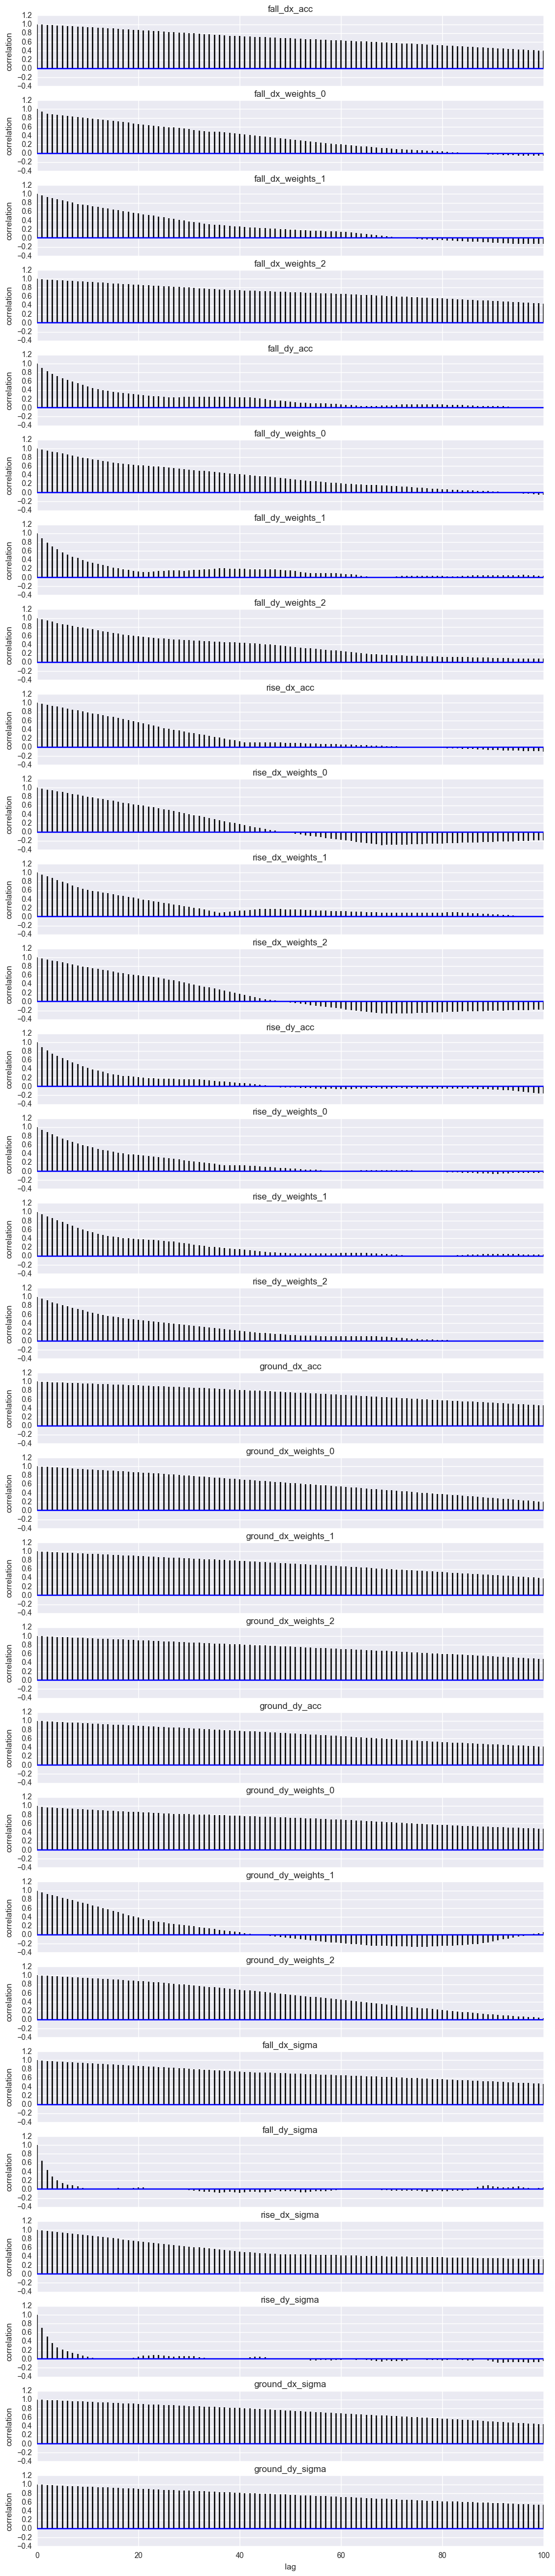

In [298]:
pm.autocorrplot(traceLinearAndClip[len(traceLinearAndClip)*0.75:])

In [301]:
pm.stats.summary(traceLinearAndClip[len(traceLinearAndClip)*0.75:-1:10])


fall_dx_acc:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.000            0.000            0.000            [0.000, 0.000]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.000          0.000          0.000          0.000          0.000


fall_dx_weights:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  1.000            0.000            0.000            [1.000, 1.000]
  0.000            0.000            0.000            [0.000, 0.000]
  0.000            0.000            0.000            [0.000, 0.000]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  1.000          1.000 

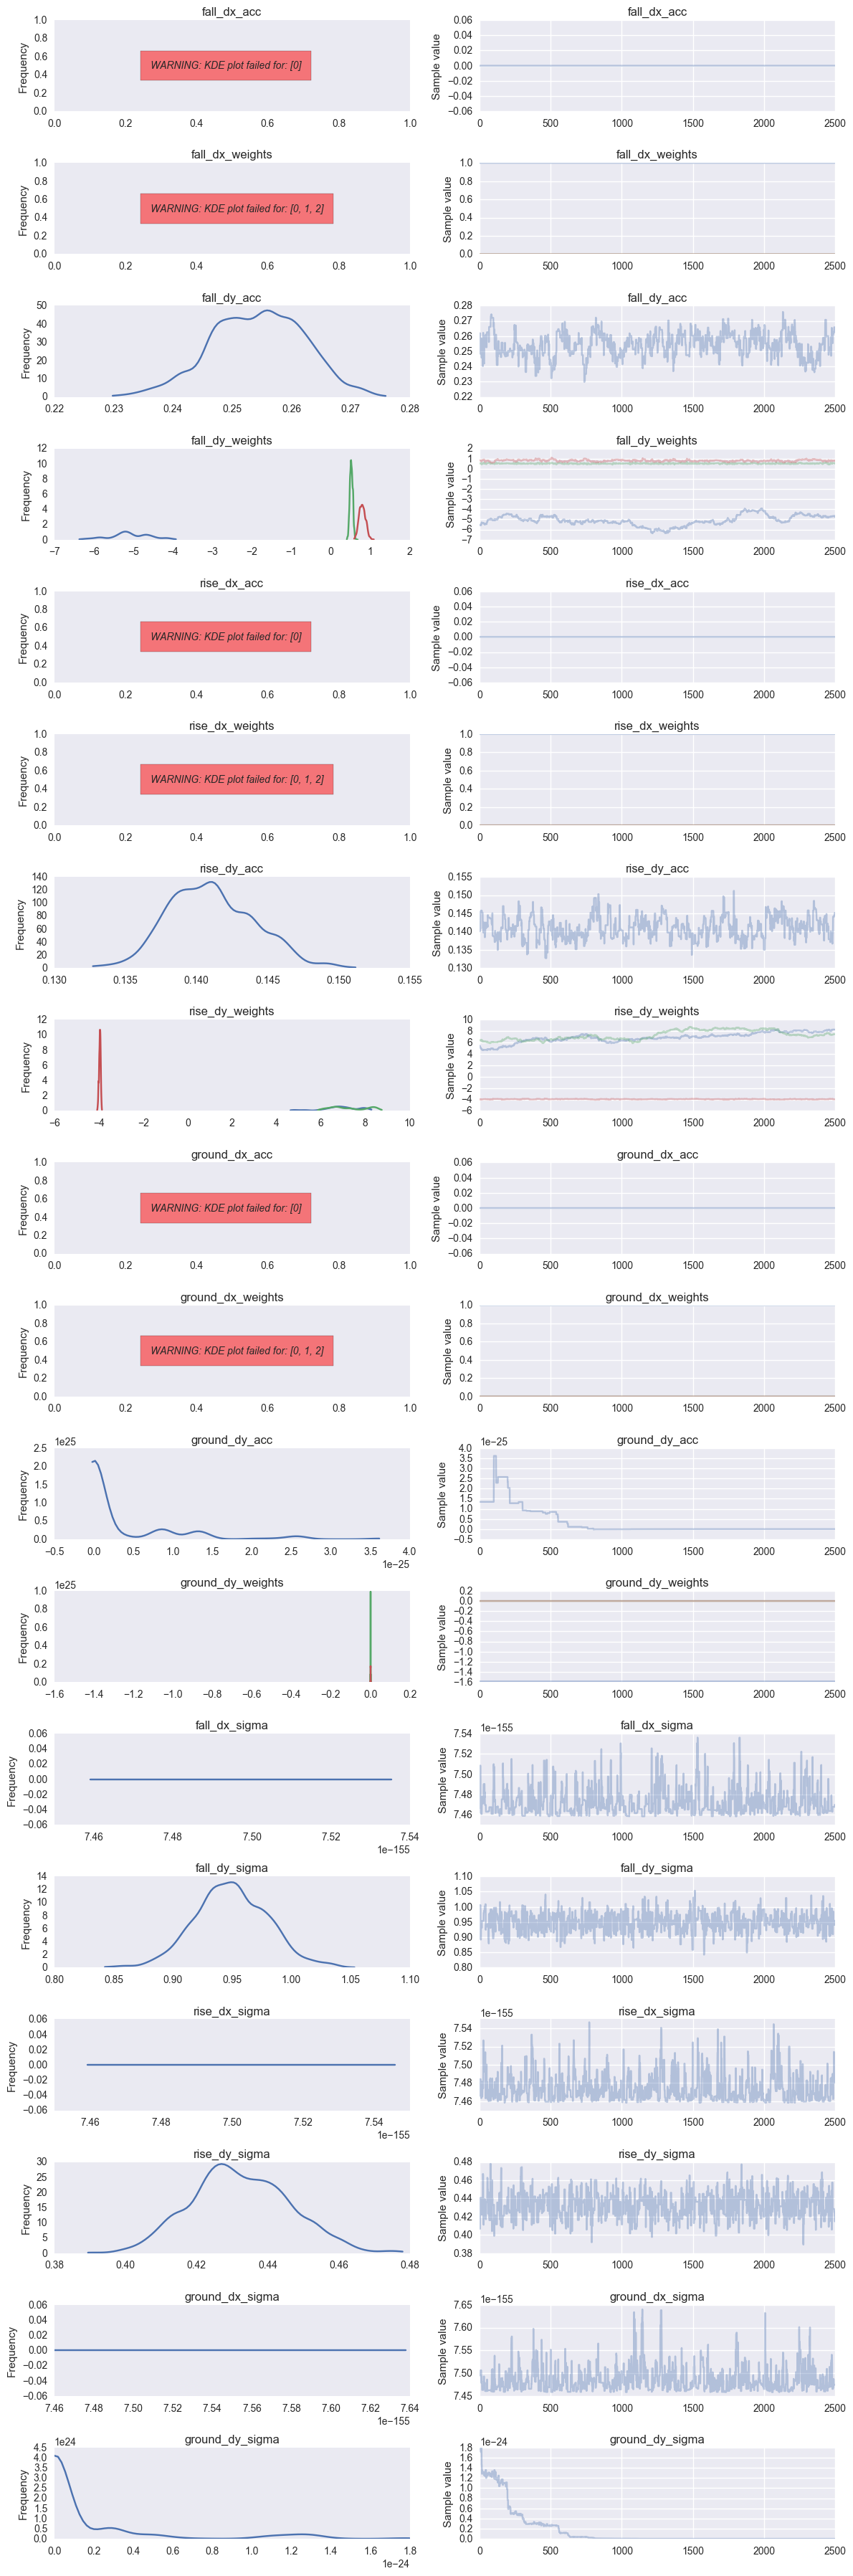

In [280]:
plt.figure(figsize=(6, 6))
pm.traceplot(traceLinearAndClip[len(traceLinearAndClip)*0.75:-1])
plt.tight_layout();

In [119]:
ppc = pm.sample_ppc(traceLinearAndClip, samples=500, model=modelLinearAndClip, size=100)

In [133]:
ppc["rise_dy"].mean()

-2.7790133371564689

In [193]:
# Visualize the initial approach with resets
# EXECUTE ME right after the first model (the one with resets)
from jumpfinder import marioModel,DT
import copy
samples = 200
m = copy.deepcopy(marioModel)

realYs = []
for (_moves,stats) in trials:
    realYs = realYs + stats.y.allVals
plt.figure(figsize=(20,10))

sample = 0
for rand_trace in np.random.randint(1000, len(traceReset), samples):
    sample += 1
    t = traceReset[rand_trace]
    m.params["gravity"].update(t["fall_dy_acc"]/(DT*DT),True)
    m.params["risingGravity"].update(t["rise_dy_acc"]/(DT*DT),True)
    m.params["minButtonDuration"].update(minHold*DT,True)
    m.params["maxButtonDuration"].update(maxHold*DT,True)
    if t["rise_dy_reset"] != 0:
        m.params["jumpStartSpeed"].update(t["rise_dy_resetval"]/DT,True)
    else:
        m.params["jumpStartSpeed"].update(0,True)
    if t["fall_dy_reset"] != 0:
        m.params["jumpToFallStartSpeed"].update(t["fall_dy_resetval"]/DT,True)
    else:
        m.params["jumpToFallStartSpeed"].update(0,True)
    modelYs = []
    for (moves,stats) in trials:
        val = m.makeValuation({("x", 0): stats.x.allVals[0], ("y", 0): stats.y.allVals[0]})
        modelYs.append(val.variables[("y",0)])
        for mi,move in enumerate(moves):
            m.step(val, 
                   DT, 
                   set(["jump"] if move & jumpButton else []), 
                   set([("bottom", "ground")] if val.variables[("y", 0)] > stats.y.allVals[0]-1 and mi >= 5 else []))
            modelYs.append(val.variables[("y",0)])
    plt.plot(modelYs,"x-")
plt.plot(realYs,"o")
plt.gca().invert_yaxis()
plt.show()

NameError: name 'traceReset' is not defined

In [ ]:
traceLinearAndClip[5000]

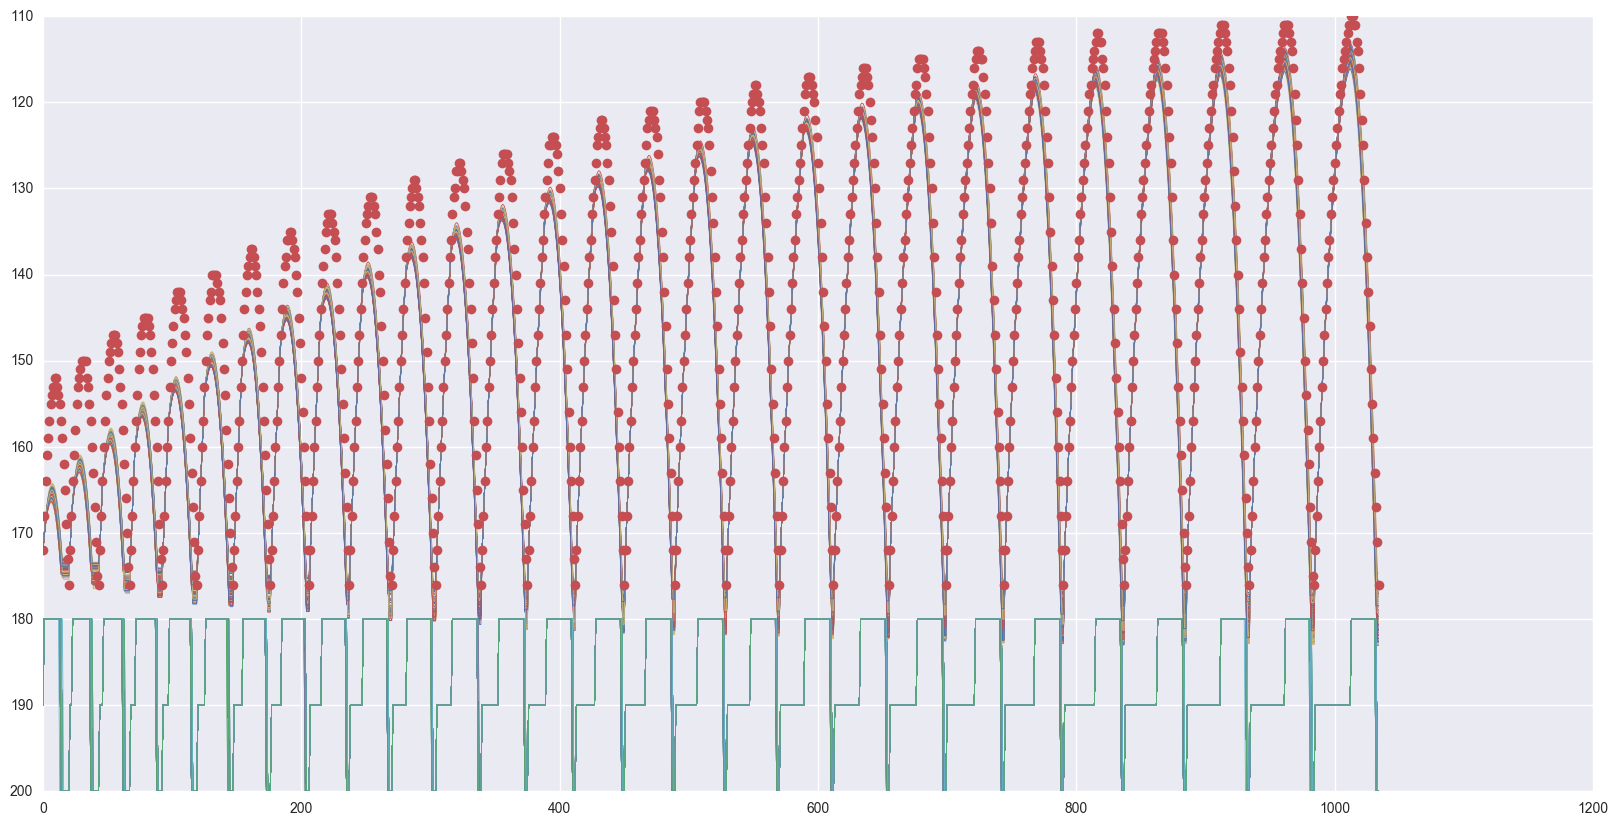

In [302]:
# Visualize the new approach with a weight vector and clipping.
# EXECUTE ME after setting up the third model (no resets, no matrix-ization)
reload(jumpfinder)
from jumpfinder import marioModel,DT
#
import copy
samples = 100
m = copy.deepcopy(marioModel)

realYs = []
for (_moves,stats) in trials:
    realYs = realYs + stats.y.allVals
plt.figure(figsize=(20,10))
sample = 0
for rand_trace in np.random.randint(len(traceLinearAndClip)*0.75, len(traceLinearAndClip), samples):
    sample += 1
    t = traceLinearAndClip[rand_trace]
    m.params["gravity"].update(t["fall_dy_acc"]/(DT*DT),True)
    m.params["risingGravity"].update(t["rise_dy_acc"]/(DT*DT),True)
    m.params["minButtonDuration"].update(minHold*DT,True)
    m.params["maxButtonDuration"].update(maxHold*DT,True)
    
    # set the jumpStartSpeed to the expression rise_dy_const + rise_weights_dy*(dx,dy).
    #  be sure that these use the pre-transition values during transitions!
    m.params["jumpStartSpeed"] = ("+", 
                                    t["rise_dy_weights"][2]/DT,
                                    ("+", 
                                     ("*", t["rise_dy_weights"][0], ("x", 1)),
                                     ("*", t["rise_dy_weights"][1], ("y", 1))))
    m.params["jumpToFallStartSpeed"] = ("+", 
                                    t["fall_dy_weights"][2]/DT,
                                    ("+", 
                                     ("*", t["fall_dy_weights"][0], ("x", 1)),
                                     ("*", t["fall_dy_weights"][1], ("y", 1))))

    

    # then do jump trials with horizontal speed and make sure we learn the right weights.
    # then try to learn the clipping for earlyOutClipVel and other discrete velocity updates
    modelYs = []
    modelModes = []
    mode_nums = {"ground": 200, "up": 190, "down": 180}
    for trial, (moves,stats) in enumerate(trials):
        val = m.makeValuation({("x", 0): stats.x.allVals[0], ("y", 0): stats.y.allVals[0]})
        for mi,move in enumerate(moves):
            m.step(val, 
                   DT, 
                   set(["jump"] if move & jumpButton else []), 
                   set([("bottom", "ground")] if val.variables[("y", 0)] > stats.y.allVals[0]-1 and mi >= 5 else []))
            modelModes.append(mode_nums[val.state])
            modelYs.append(val.variables[("y",0)])
        modelYs.append(modelYs[-1])
        modelModes.append(mode_nums[val.state])
    plt.plot(modelYs,"x-",lw=0.6)
    plt.plot(modelModes,"+-",lw=0.6)
plt.plot(realYs,"o")
plt.gca().invert_yaxis()
plt.show()